In [ ]:
#note that the Neural Network code was used twice, once with the original dataframe, and then once again with the embedded dataframe

In [68]:
from tensorflow.python.client import device_lib

In [69]:
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8535353023534165772
]


In [71]:
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from tensorflow import keras
import os
import re
import pandas as pd
import numpy as np
print(tf.__version__)
df = pd.read_csv('F:\Files from Linux/datawithembedding.csv')

2.1.0


C:\Anaconda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (36,37,38,39,40,42,43,44,45,48,49,50,52,54,58,59,61,62) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [72]:
df['target'].replace(to_replace=['Negative', 'Neutral', 'Positive'],
           value= [2, 0, 1], 
           inplace=True)

In [73]:
df.drop(['Unnamed: 0', 'Unnamed: 0.1', 'txt_link','doc_name', 'release_date_day', 'adj_day',
 'Date','Adj Close',
 'ChangevLastadjustedclose',
 'S&Pmovement',
 'ChangeVS&P500',
 'Classification ','join date',
 'Quarter end','text_len',
# 'cleantext',
 'cleantextlen',
 'tag','items','ticker',
 'cik',], axis=1, inplace=True)

In [74]:
df.drop(['filtered_text'], axis=1, inplace=True)

In [75]:
NUMERIC_COLUMNS = [
 'afterhours',
 'Volume',
 'Shares',
 'Shares split adjusted',
 'Split factor',
 'Assets',
 'Current Assets',
 'Liabilities',
 'Current Liabilities',
 'Shareholders equity',
 'Non-controlling interest',
 'Preferred equity',
 'Goodwill & intangibles',
 'Long-term debt',
 'Revenue',
 'Earnings',
 'Earnings available for common stockholders',
 'EPS basic',
 'EPS diluted',
 'Dividend per share',
 'Cash from operating activities',
 'Cash from investing activities',
 'Cash from financing activities',
 'Cash change during period',
 'Cash at end of period',
 'Capital expenditures',
 'Price',
 'Price high',
 'Price low',
 'ROE',
 'ROA',
 'Book value of equity per share',
 'P/B ratio',
 'P/E ratio',
 'Cumulative dividends per share',
 'Dividend payout ratio',
 'Long-term debt to equity ratio',
 'Equity to assets ratio',
 'Net margin',
 'Free cash flow per share',
 'Current ratio']

In [76]:
list(df.columns.values) 

['Unnamed: 0.1.1',
 'GICS Sector',
 'GICS Sub Industry',
 'release_date',
 'afterhours',
 'Volume',
 'target',
 'Shares',
 'Shares split adjusted',
 'Split factor',
 'Assets',
 'Current Assets',
 'Liabilities',
 'Current Liabilities',
 'Shareholders equity',
 'Non-controlling interest',
 'Preferred equity',
 'Goodwill & intangibles',
 'Long-term debt',
 'Revenue',
 'Earnings',
 'Earnings available for common stockholders',
 'EPS basic',
 'EPS diluted',
 'Dividend per share',
 'Cash from operating activities',
 'Cash from investing activities',
 'Cash from financing activities',
 'Cash change during period',
 'Cash at end of period',
 'Capital expenditures',
 'Price',
 'Price high',
 'Price low',
 'ROE',
 'ROA',
 'Book value of equity per share',
 'P/B ratio',
 'P/E ratio',
 'Cumulative dividends per share',
 'Dividend payout ratio',
 'Long-term debt to equity ratio',
 'Equity to assets ratio',
 'Net margin',
 'Asset turnover',
 'Free cash flow per share',
 'Current ratio',
 'item',
 '0

In [77]:
df.drop(['item','GICS Sector', 'GICS Sub Industry'], axis=1, inplace=True)

In [78]:
df = df.sort_values(by='release_date', ascending=True, axis=0)

df.drop(['release_date'], axis=1, inplace=True)

df.dropna(subset=['Revenue'],inplace=True)

for feature_name in NUMERIC_COLUMNS:
    df[feature_name] = pd.to_numeric(df[feature_name], errors='coerce').fillna(0)
    
g = df.columns.to_series().groupby(df.dtypes).groups
print(g)

testNum = int(len(df) * -.1)

train = df[:testNum]
test = df[testNum:]
y_train= train['target']
y_test= test['target']

{dtype('int64'): Index(['Unnamed: 0.1.1', 'afterhours', 'target'], dtype='object'), dtype('float64'): Index(['Volume', 'Shares', 'Shares split adjusted', 'Split factor', 'Assets',
       'Current Assets', 'Liabilities', 'Current Liabilities',
       'Shareholders equity', 'Non-controlling interest',
       ...
       '758', '759', '760', '761', '762', '763', '764', '765', '766', '767'],
      dtype='object', length=808), dtype('O'): Index(['Asset turnover'], dtype='object')}


In [79]:
print(len(df))
print(len(test))
print(len(train))

8253
825
7428


In [80]:
train.drop(['target'], axis=1, inplace=True)
test.drop(['target'], axis=1, inplace=True)

C:\Anaconda\envs\tf-gpu\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [93]:
print(len(list(test.columns.values)))

811


In [82]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = []
#'GICS Sector',
# 'GICS Sub Industry','item'
NUMERIC_COLUMNS = [
 'afterhours',
 'Volume',
 'Shares',
 'Shares split adjusted',
 'Split factor',
 'Assets',
 'Current Assets',
 'Liabilities',
 'Current Liabilities',
 'Shareholders equity',
 'Non-controlling interest',
 'Preferred equity',
 'Goodwill & intangibles',
 'Long-term debt',
 'Revenue',
 'Earnings',
 'Earnings available for common stockholders',
 'EPS basic',
 'EPS diluted',
 'Dividend per share',
 'Cash from operating activities',
 'Cash from investing activities',
 'Cash from financing activities',
 'Cash change during period',
 'Cash at end of period',
 'Capital expenditures',
 'Price',
 'Price high',
 'Price low',
 'ROE',
 'ROA',
 'Book value of equity per share',
 'P/B ratio',
 'P/E ratio',
 'Cumulative dividends per share',
 'Dividend payout ratio',
 'Long-term debt to equity ratio',
 'Equity to assets ratio',
 'Net margin',
 'Free cash flow per share',
 'Current ratio',
 'Asset turnover']
    




In [83]:
from numpy import array
from numpy import argmax
from keras.utils import to_categorical
# define example
#data = df['item']
#data = array(data)
#print(data)
# one hot encode
#encoded = to_categorical(data)
#print(encoded)
# invert encoding
#inverted = argmax(encoded[0])
#print(inverted)

In [52]:
#train = train[NUMERIC_COLUMNS]

In [84]:
for feature_name in NUMERIC_COLUMNS:
    train[feature_name] = pd.to_numeric(train[feature_name], errors='coerce').fillna(0)

C:\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [85]:
from sklearn import preprocessing
# Get column names first
names = train.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
train = scaler.fit_transform(train)
train = pd.DataFrame(train, columns=names)

In [86]:
# Train the model
from sklearn.linear_model import LogisticRegression

# Set regularization rate
reg = 0.01

# train a logistic regression model on the training set
clf = LogisticRegression(C=1/reg, solver='lbfgs', max_iter = 100000, multi_class='multinomial').fit(train, y_train)


print (clf)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [87]:
#test = test[NUMERIC_COLUMNS]
for feature_name in NUMERIC_COLUMNS:
    test[feature_name] = pd.to_numeric(test[feature_name], errors='coerce').fillna(0)
names = test.columns
# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
test = scaler.fit_transform(test)
test = pd.DataFrame(test, columns=names)

C:\Anaconda\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [88]:
predictions = clf.predict(test)
print('Predicted labels: ', predictions)
print('Actual labels: ' ,y_test)

Predicted labels:  [0 0 0 1 1 1 0 2 0 0 1 0 1 1 0 0 0 2 0 2 0 0 0 1 2 1 2 2 1 1 0 0 2 0 0 0 1
 1 2 0 0 0 2 1 2 0 0 2 2 2 0 1 1 1 0 1 2 0 0 0 0 2 0 1 2 2 2 2 0 2 1 1 1 2
 2 0 2 2 2 1 1 1 1 1 1 2 2 2 0 1 2 2 0 2 0 1 0 1 2 0 1 1 1 2 1 2 0 1 2 1 0
 2 2 1 2 0 2 1 0 1 0 0 1 1 1 0 0 2 1 1 2 2 0 0 0 0 2 0 2 1 1 2 2 1 0 2 2 2
 0 0 1 0 2 1 2 1 2 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 2 0 1 1 1 2 2 2 1 0 0 0
 0 2 0 0 1 2 1 2 2 0 2 0 1 0 0 0 0 0 1 1 2 1 2 1 2 1 0 0 0 1 1 0 1 0 2 2 1
 0 2 0 2 1 0 2 0 2 0 0 2 0 0 2 0 1 2 2 1 2 0 2 0 1 2 2 1 2 2 1 1 1 1 2 1 2
 1 0 0 1 0 1 1 2 1 1 0 2 1 2 1 0 0 1 1 0 0 1 1 0 2 2 2 2 2 2 0 2 1 1 0 1 1
 0 2 0 0 1 0 2 2 2 0 2 1 1 1 1 2 2 0 0 2 2 2 2 1 0 1 2 0 1 1 1 2 2 1 2 0 0
 1 1 1 0 2 0 2 0 2 0 0 1 2 0 2 1 1 0 2 0 2 0 2 2 2 2 1 1 2 0 0 0 2 1 2 0 1
 2 0 2 0 0 0 2 2 0 1 2 0 2 1 0 0 0 0 2 1 0 2 2 1 0 2 2 2 1 0 2 0 0 2 0 0 2
 2 2 2 1 0 1 0 2 0 0 2 1 1 0 2 2 2 1 2 1 1 2 1 1 1 0 2 1 1 1 2 1 2 1 0 1 0
 0 0 0 1 0 1 1 1 2 1 2 2 0 1 2 1 0 2 2 0 1 2 2 0 1 1 0 2 1 2 2 2 2 2 2 1 2
 1 0 2

In [89]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
print('Accuracy: ', accuracy_score(y_test, predictions))

Accuracy:  0.3466666666666667


In [90]:
from sklearn. metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.40      0.33      0.37       314
           1       0.37      0.36      0.37       288
           2       0.27      0.35      0.30       223

    accuracy                           0.35       825
   macro avg       0.35      0.35      0.35       825
weighted avg       0.36      0.35      0.35       825



In [91]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)

[[105  97 112]
 [ 86 103  99]
 [ 70  75  78]]


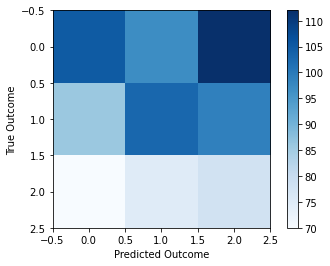

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
#tick_marks = np.arange(len(test.[target))
#plt.xticks(tick_marks, test.target, rotation=45)
#plt.yticks(tick_marks, test.target)
plt.xlabel("Predicted Outcome")
plt.ylabel("True Outcome")
plt.show()

In [26]:
print(train)

      afterhours    Volume    Shares  Shares split adjusted  Split factor  \
0       0.926746 -0.370400 -0.459307              -0.461735     -0.090947   
1       0.926746  0.203506 -0.305764              -0.308169     -0.090947   
2      -1.079044 -0.375210 -0.332925              -0.335334     -0.090947   
3       0.926746 -0.344561 -0.305764              -0.308169     -0.090947   
4       0.926746 -0.156193 -0.303066              -0.305471     -0.090947   
...          ...       ...       ...                    ...           ...   
7423   -1.079044  0.141353  2.265038               2.263015     -0.090947   
7424   -1.079044 -0.417065 -0.433289              -0.435713     -0.090947   
7425   -1.079044 -0.312417  0.417720               0.415422     -0.090947   
7426   -1.079044 -0.161487  0.974300               0.972085     -0.090947   
7427    0.926746 -0.319373 -0.233897              -0.236291     -0.090947   

        Assets  Current Assets  Liabilities  Current Liabilities  \
0    -0

In [131]:
#Create a Neural Network
input_dim=811

from keras.models import Sequential

# Import `Dense` from `keras.layers`
from keras.layers import Dense

model = Sequential()
model.add(Dense(200, input_dim=input_dim, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

In [132]:
model.fit(train, y_train,epochs=10, batch_size=1, verbose=1)

Epoch 1/10
7428/7428 [==============================] - 6s 809us/step - loss: 1.1039 - accuracy: 0.3654
Epoch 2/10
7428/7428 [==============================] - 6s 747us/step - loss: 1.0904 - accuracy: 0.3858
Epoch 3/10
7428/7428 [==============================] - 6s 777us/step - loss: 1.0726 - accuracy: 0.4086
Epoch 4/10
7428/7428 [==============================] - 6s 783us/step - loss: 1.0280 - accuracy: 0.4646
Epoch 5/10
7428/7428 [==============================] - 6s 808us/step - loss: 0.9535 - accuracy: 0.5219
Epoch 6/10
7428/7428 [==============================] - 5s 734us/step - loss: 0.8666 - accuracy: 0.5817
Epoch 7/10
7428/7428 [==============================] - 6s 769us/step - loss: 0.7815 - accuracy: 0.6403
Epoch 8/10
7428/7428 [==============================] - 5s 725us/step - loss: 0.6836 - accuracy: 0.6905
Epoch 9/10
7428/7428 [==============================] - 6s 746us/step - loss: 0.5896 - accuracy: 0.7348
Epoch 10/10
7428/7428 [==============================] - 6s 835u

In [ ]:
#37.92 the limit?

In [133]:
score = model.evaluate(test, y_test,verbose=1)

print(score)

825/825 [==============================] - 0s 39us/step
[1.7341458534471916, 0.3527272641658783]


In [134]:
predictions = model.predict(test)
predicted = []
for row in predictions:
    a = argmax(row)
    predicted.append(a)
predictions = predicted    

In [135]:
print('Accuracy: ', accuracy_score(y_test, predictions))

Accuracy:  0.3527272727272727


In [136]:
from sklearn. metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.40      0.37      0.39       314
           1       0.35      0.41      0.38       288
           2       0.28      0.25      0.26       223

    accuracy                           0.35       825
   macro avg       0.35      0.34      0.34       825
weighted avg       0.35      0.35      0.35       825



In [139]:
from sklearn.metrics import confusion_matrix

# Print the confusion matrix
cm = confusion_matrix(y_test, predictions)
print(cm)

[[117 128  69]
 [ 98 119  71]
 [ 74  94  55]]


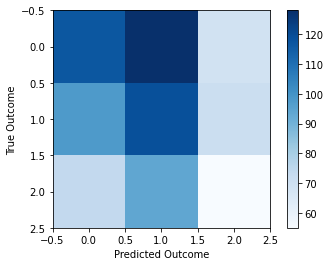

In [140]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
#tick_marks = np.arange(len(test.[target))
#plt.xticks(tick_marks, test.target, rotation=45)
#plt.yticks(tick_marks, test.target)
plt.xlabel("Predicted Outcome")
plt.ylabel("True Outcome")
plt.show()

In [68]:
#Create Embeddings
from keras_bert import extract_embeddings

model_path = "C:/Users\KennethLulie/.keras/datasets/multi_cased_L-12_H-768_A-12"

In [69]:
from keras_bert import get_pretrained, PretrainedList, get_checkpoint_paths

model_path = get_pretrained(PretrainedList.multi_cased_base)
paths = get_checkpoint_paths(model_path)
print(paths.config, paths.checkpoint, paths.vocab)

C:\Users\Pringles De Can\.keras\datasets\multi_cased_L-12_H-768_A-12\bert_config.json C:\Users\Pringles De Can\.keras\datasets\multi_cased_L-12_H-768_A-12\bert_model.ckpt C:\Users\Pringles De Can\.keras\datasets\multi_cased_L-12_H-768_A-12\vocab.txt


In [70]:
df2 = pd.read_csv('F:\Files from Linux/cleaneddataset.csv')

C:\Anaconda\envs\tf-gpu\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (35,36,37,38,39,41,42,43,47,48,49,51,60,61) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [72]:
texts = df2['cleantext']

In [ ]:
from keras_bert import extract_embeddings, POOL_NSP, POOL_MAX
embeddings = extract_embeddings(model_path, texts, poolings=[POOL_MAX])
dataframe = pd.DataFrame.from_records(embeddings)